In [17]:

# !pip install pandas numpy seaborn matplotlib genshim sklearn

# !pip install kagglehub underthesea tqdm
# !pip install transformer touch re

# !pip install googletrans==4.0.0-rc1


# Resources

- **NLTK Parser (Vietnamese Tokenization):** [Underthesea Documentation](https://underthesea.readthedocs.io/en/latest/readme.html)  
- **Corpus Dataset:** [Pham Tuyet - Vietnamese Text Classification Dataset on Kaggle](https://www.kaggle.com/datasets/phamtuyet/text-classification?select=text_tokenizer.xlsx)  
- **Stopword Dataset:** [L3VIEVIL - Vietnamese Stopwords on Kaggle](https://www.kaggle.com/datasets/linhlpv/vietnamese-stopwords)


# Vietnamese Text Processing: Lemmatization and Tokenization

### Why Vietnamese doesn't need lemmatization
asd
Unlike languages such as English, where words can have multiple inflected forms (e.g., *run, runs, running, ran*), Vietnamese words typically **remain in their root form** regardless of tense, number, or gender.  

This is because Vietnamese is an **analytic language**, where grammatical relationships are expressed using separate function words or word order rather than inflection.  

**Example:**  

| Vietnamese | English |
|------------|---------|
| ăn        | eat     |
| ăn         | ate     |
| ăn        | eating  |

Here, the word `ăn` does not change form. Therefore, **lemmatization is generally unnecessary**, and we can work directly with the raw word tokens for text analysis.

---

### How Vietnamese tokenization works

In Vietnamese, **words are usually made up of one or more syllables separated by spaces**, which means naive whitespace splitting will often split a single word into multiple tokens. Therefore, proper tokenization is needed to identify **multi-syllable words** as single units.

We use [**underthesea**](https://underthesea.readthedocs.io/en/latest/api.html#word-tokenize)  for tokenization.  

**Example:**
```python
from underthesea import word_tokenize
sentence = "Bác sĩ bây giờ có thể thản nhiên báo tin bệnh nhân bị ung thư"
# "Doctors can now calmly deliver the news that a patient has cancer."


tokenized = word_tokenize(sentence, format="text")
# tokenized = "Bác_sĩ bây_giờ có_thể thản_nhiên báo_tin bệnh_nhân bị ung_thư"


In [18]:
# Core Imports 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os
import warnings

from datasets import load_dataset
import kagglehub
from underthesea import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from googletrans import Translator
from tqdm.auto import tqdm

# Set up
warnings.simplefilter("ignore") 
tqdm.pandas(desc="Processing") 

# Define folder for saving results
PKL_FOLDER = 'pkl_folder'
if not os.path.exists(PKL_FOLDER):
    os.makedirs(PKL_FOLDER)
    print(f"Created directory: {PKL_FOLDER}")

# Use Google Translator
try:
    translator = Translator()
    print("Google Translator initialized.")
    def translate_words(words_list): 
        translations = []
        for word in words_list:
            try:
                translated = translator.translate(word, src='vi', dest='en')
                translations.append(translated.text if hasattr(translated, 'text') else word)
            except Exception as e:
                translations.append("Error")
        return translations
except Exception as e:
    print(f"Could not initialize translator: {e}")
    translator = None





Google Translator initialized.


In [19]:
# Define the English mapping before loading the data
LABEL_MAPPING = {
    'chinh-tri': 'Politics',
    'doi-song': 'Daily_Life',
    'giao-duc': 'Education',
    'kinh-doanh': 'Business',
    'phap-luat': 'Law',
    'suc-khoe': 'Health',
    'the-gioi': 'World',
    'the-thao': 'Sports'
}


# Load Dataset
try:
    # Use kagglehub to download if not already done
    news_dataset_path = kagglehub.dataset_download('phamtuyet/text-classification')
    print("News dataset downloaded/located via kagglehub.")
except Exception as e:
    print(f"Error downloading/finding news dataset via kagglehub: {e}")


# Load the News dataset
if news_dataset_path and os.path.exists(os.path.join(news_dataset_path, 'text.xlsx')):
    print("Loading full news dataset...")
    # Load the excel file 
    full_news_df = pd.read_excel(
        os.path.join(news_dataset_path, 'text.xlsx'),
        header=None,
        names=['content', 'label'] 
    )
    print("Full news dataset loaded.")

    full_news_df = full_news_df[full_news_df['label'] != 'label'].copy()

    # Create a Balanced Subset (since the dataset is quite large)
    N_SAMPLES_PER_CATEGORY = 2000 

    # Group by category, take N samples, and recombine
    vn_df_news_subset = full_news_df.groupby('label', group_keys=False).apply(
        lambda x: x.sample(min(len(x), N_SAMPLES_PER_CATEGORY), random_state=2)
    )

    print("Subset created.")
    vn_df = vn_df_news_subset.reset_index(drop=True)

    # Apply English label mapping 
    vn_df['label'] = vn_df['label'].map(LABEL_MAPPING)

    print("\nNew DataFrame (vn_df) Info:")
    vn_df.info()
    print("\nCategory distribution in the subset (English Labels):")
    print(vn_df['label'].value_counts())

else:
    print("Error: Could not load the news dataset file. Please check the path.")

News dataset downloaded/located via kagglehub.
Loading full news dataset...
Full news dataset loaded.
Subset created.

New DataFrame (vn_df) Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  16000 non-null  object
 1   label    16000 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB

Category distribution in the subset (English Labels):
label
Politics      2000
Daily_Life    2000
Education     2000
Business      2000
Law           2000
Health        2000
World         2000
Sports        2000
Name: count, dtype: int64


In [20]:
# Load Stopword
print("Loading Vietnamese stopwords...")
stopword_path = kagglehub.dataset_download("linhlpv/vietnamese-stopwords")
stopword_df = pd.read_csv(f'{stopword_path}/vietnamese-stopwords.txt', header=None, names=['word'])
vietnamese_stopwords_set = set(stopword_df['word'].tolist())
print(f"Loaded {len(vietnamese_stopwords_set)} stopwords into a set.")

Loading Vietnamese stopwords...
Loaded 1942 stopwords into a set.


# Question 1: Estimates Stopword Proportion

In [21]:
TASK1_STATS_PKL = os.path.join(PKL_FOLDER, 'task1.pkl') 

from collections import Counter

# Check if cached file exists
if os.path.exists(TASK1_STATS_PKL):
    print(f"Loading cached Task 1 results from {TASK1_STATS_PKL}...")
    with open(TASK1_STATS_PKL, 'rb') as f:
        data = pickle.load(f)
    stats_df_task1 = data["df"]
    stopword_freq_by_cat = data["stopwords"]
    print("Task 1 results loaded.")
else:
    print(f"Cache not found for Task 1. Running analysis...")

    # Initialize dictionary to store stopword counts per category
    stopword_freq_by_cat = {cat: Counter() for cat in vn_df['label'].unique()}

    # Function to process text and collect stopwords
    def process_text_task1(row):
        text, category = row['content'], row['label']
        tokens = word_tokenize(str(text).lower())
        stopwords = [t for t in tokens if t in vietnamese_stopwords_set]
        stopword_freq_by_cat[category].update(stopwords)
        return pd.Series({
            'total_tokens': len(tokens),
            'stopword_tokens': len(stopwords)
        })

    print("Tokenizing sentences and collecting stopwords for Task 1...")
    token_counts_df = vn_df.progress_apply(process_text_task1, axis=1)

    # Combine counts with news labels
    CATEGORY_COLUMN = 'label'
    results_df = pd.concat([vn_df[CATEGORY_COLUMN], token_counts_df], axis=1)

    # Aggregate by category
    stats_df_task1 = results_df.groupby(CATEGORY_COLUMN).sum()

    # Calculate proportion
    stats_df_task1['Stopword Proportion (%)'] = (
        stats_df_task1['stopword_tokens'] / stats_df_task1['total_tokens']
    ) * 100

    # Reset index and keep category names
    stats_df_task1 = stats_df_task1.reset_index().rename(columns={CATEGORY_COLUMN: 'Category'})

    # Save results
    print(f"Task 1 analysis complete. Saving results to {TASK1_STATS_PKL}...")
    with open(TASK1_STATS_PKL, 'wb') as f:
        pickle.dump({"df": stats_df_task1, "stopwords": stopword_freq_by_cat}, f)
    print("Task 1 results saved.")

print("\n--- Top 10 Stopwords by Category ---")
for category, counter in stopword_freq_by_cat.items():
    print(f"\nCategory: {category}")
    top_words = [w for w, _ in counter.most_common(10)]
    counts = [c for _, c in counter.most_common(10)]
    translated_words = translate_words(top_words)
    df_display = pd.DataFrame({
        'Stopword (VI)': top_words,
        'Translation (EN)': translated_words,
        'Frequency': counts
    })
    print(df_display.to_markdown(index=False))


Loading cached Task 1 results from pkl_folder\task1.pkl...
Task 1 results loaded.

--- Top 10 Stopwords by Category ---

Category: Politics
| Stopword (VI)   | Translation (EN)   |   Frequency |
|:----------------|:-------------------|------------:|
| và              | and                |       22508 |
| các             | the                |       19155 |
| của             | belong to          |       19067 |
| có              | Have               |       12986 |
| trong           | in                 |       12294 |
| là              | To be              |       11056 |
| được            | Okay               |        8990 |
| về              | about              |        8794 |
| đã              | Satisfied          |        8759 |
| cho             | give               |        8616 |

Category: Daily_Life
| Stopword (VI)   | Translation (EN)   |   Frequency |
|:----------------|:-------------------|------------:|
| và              | and                |       17288 |
| là         

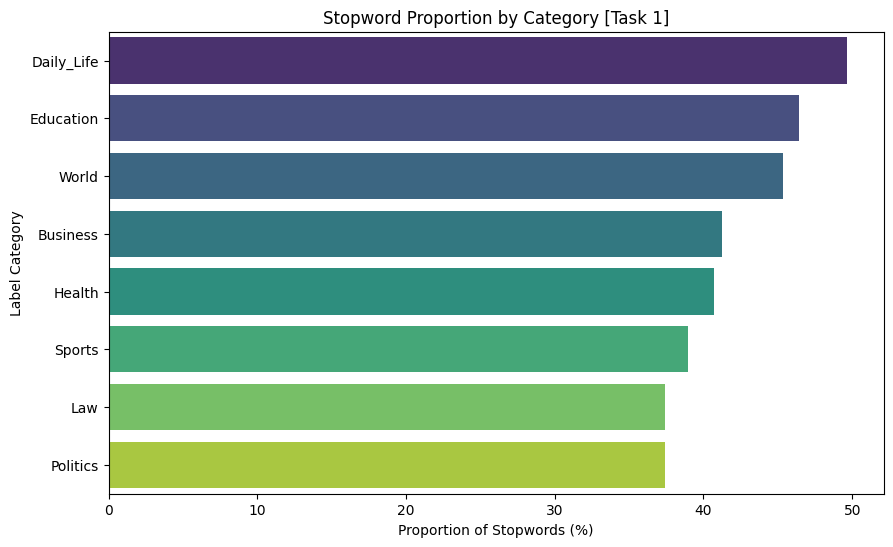

In [22]:
# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Stopword Proportion (%)',
    y='Category',
    data=stats_df_task1.sort_values('Stopword Proportion (%)', ascending=False),
    palette='viridis'
)
plt.title('Stopword Proportion by Category [Task 1]')
plt.xlabel('Proportion of Stopwords (%)')
plt.ylabel('Label Category')
plt.savefig('plot/task1.png', dpi=300, bbox_inches='tight')
plt.show()

# Question 2: TF-IDF Statistics for Stopwords

In [23]:

from scipy.sparse import vstack
from sklearn.feature_extraction.text import TfidfVectorizer



TASK2_TFIDF_PKL = os.path.join(PKL_FOLDER, 'task2.pkl')

if os.path.exists(TASK2_TFIDF_PKL):
    print(f"Loading cached Task 2 results from {TASK2_TFIDF_PKL}...")
    with open(TASK2_TFIDF_PKL, 'rb') as f:
        task2_data = pickle.load(f)
        
    tfidf_stats_df = task2_data['stats_df']
    stopword_tfidf_scores = task2_data['category_scores']
    categories = task2_data['categories']
    print("Results loaded.")

else:
    print(f"Cache not found for Task 2. Running analysis...")

    # Define tokenizer
    def vn_tokenizer(text):
        return word_tokenize(str(text).lower())

    categories = vn_df['label'].unique()
    
    stopword_vocab_list = sorted(list(vietnamese_stopwords_set))
    stopword_tfidf_scores = {word: [] for word in stopword_vocab_list}

    # Vectorizer 
    tfidf_vectorizer = TfidfVectorizer(
        tokenizer=vn_tokenizer,
        vocabulary=stopword_vocab_list,
        stop_words=None
    )

    all_matrices = []  # To store matrices for global stats
    for category in tqdm(categories, desc="Processing Categories for TF-IDF"):
        category_texts = vn_df[vn_df['label'] == category]['content'].tolist()

        if not category_texts:
            print(f"  Skipping category '{category}': No texts found.")
            for stopword in stopword_vocab_list:
                stopword_tfidf_scores[stopword].append(0.0)
            continue

        try:
            # Fit/transform
            tfidf_matrix = tfidf_vectorizer.fit_transform(category_texts)
            all_matrices.append(tfidf_matrix)
            
            # Calculate the average score for each stopword 
            avg_scores_in_category = np.mean(tfidf_matrix.toarray(), axis=0)
            
            # Store this category's average score for each stopword
            for i, stopword in enumerate(stopword_vocab_list):
                stopword_tfidf_scores[stopword].append(avg_scores_in_category[i])
            
        except ValueError as e:
            print(f"  Skipping category '{category}' due to error: {e}")
            for stopword in stopword_vocab_list:
                stopword_tfidf_scores[stopword].append(0.0)

    print("\nCalculating TF-IDF statistics (across all documents)...")
    
    if not all_matrices:
        print("No matrices generated. Creating empty results.")
        tfidf_stats_df = pd.DataFrame(columns=[
            'Stopword', 'Average TF-IDF', 'Std Dev TF-IDF',
            'Max TF-IDF', 'Min TF-IDF'
        ])
    else:
        vstack_matrices = vstack(all_matrices)
        dense_matrix = vstack_matrices.toarray()

        avgs = np.mean(dense_matrix, axis=0)
        stds = np.std(dense_matrix, axis=0)
        maxs = np.max(dense_matrix, axis=0)
        mins = np.min(dense_matrix, axis=0)
        
        tfidf_stats = []
        for i, stopword in enumerate(stopword_vocab_list):
            tfidf_stats.append({
                'Stopword': stopword,
                'Average TF-IDF': avgs[i], # This is the avg across ALL DOCS
                'Std Dev TF-IDF': stds[i],
                'Max TF-IDF': maxs[i],
                'Min TF-IDF': mins[i]
            })
        tfidf_stats_df = pd.DataFrame(tfidf_stats)

    # Save results
    print(f"Analysis complete. Saving results to {TASK2_TFIDF_PKL}...")
    task2_data = {
        'stats_df': tfidf_stats_df,
        'category_scores': stopword_tfidf_scores,
        'categories': categories
    }


    with open(TASK2_TFIDF_PKL, 'wb') as f:
        pickle.dump(task2_data, f)
    print("Task 2 results saved.")

Cache not found for Task 2. Running analysis...


Processing Categories for TF-IDF:   0%|          | 0/8 [00:00<?, ?it/s]


Calculating TF-IDF statistics (across all documents)...
Analysis complete. Saving results to pkl_folder\task2.pkl...
Task 2 results saved.


In [24]:
tfidf_stats_df_sorted = tfidf_stats_df.sort_values('Average TF-IDF')

# Get lowest 15, highest 15 
lowest_15_df = tfidf_stats_df_sorted.head(15).copy()
highest_15_df = tfidf_stats_df_sorted.tail(15).copy() 


print("\nTranslating top/bottom stopwords...")

lowest_15_df['Translation'] = translate_words(lowest_15_df['Stopword'].tolist())
highest_15_df['Translation'] = translate_words(highest_15_df['Stopword'].tolist())


print("\nTF-IDF Stats (Lowest 15 Avg TF-IDF with Translation)") 
print(lowest_15_df[['Stopword', 'Translation', 'Average TF-IDF', 'Min TF-IDF', 'Max TF-IDF']].to_markdown(index=False, floatfmt=".4f"))
print("\nTF-IDF Stats (Highest 15 Avg TF-IDF with Translation)")
print(highest_15_df[['Stopword', 'Translation', 'Average TF-IDF', 'Min TF-IDF', 'Max TF-IDF']].to_markdown(index=False, floatfmt=".4f"))


print("\nComment on Analysis:")
num_near_zero = tfidf_stats_df[tfidf_stats_df['Average TF-IDF'] < 1e-5].shape[0] 
print(f"{num_near_zero} out of {len(tfidf_stats_df)} stopwords have average TF-IDF < 1e-5.")





Translating top/bottom stopwords...

TF-IDF Stats (Lowest 15 Avg TF-IDF with Translation)
| Stopword   | Translation   |   Average TF-IDF |   Min TF-IDF |   Max TF-IDF |
|:-----------|:--------------|-----------------:|-------------:|-------------:|
| a ha       | aha           |           0.0000 |       0.0000 |       0.0000 |
| quả thế    | indeed        |           0.0000 |       0.0000 |       0.0000 |
| quả là     | indeed        |           0.0000 |       0.0000 |       0.0000 |
| quá tuổi   | too old       |           0.0000 |       0.0000 |       0.0000 |
| quá tin    | too trusting  |           0.0000 |       0.0000 |       0.0000 |
| quá thì    | too much      |           0.0000 |       0.0000 |       0.0000 |
| quá nhiều  | too much      |           0.0000 |       0.0000 |       0.0000 |
| quá mức    | excessive     |           0.0000 |       0.0000 |       0.0000 |
| quá lời    | too much      |           0.0000 |       0.0000 |       0.0000 |
| quả vậy    | indeed        

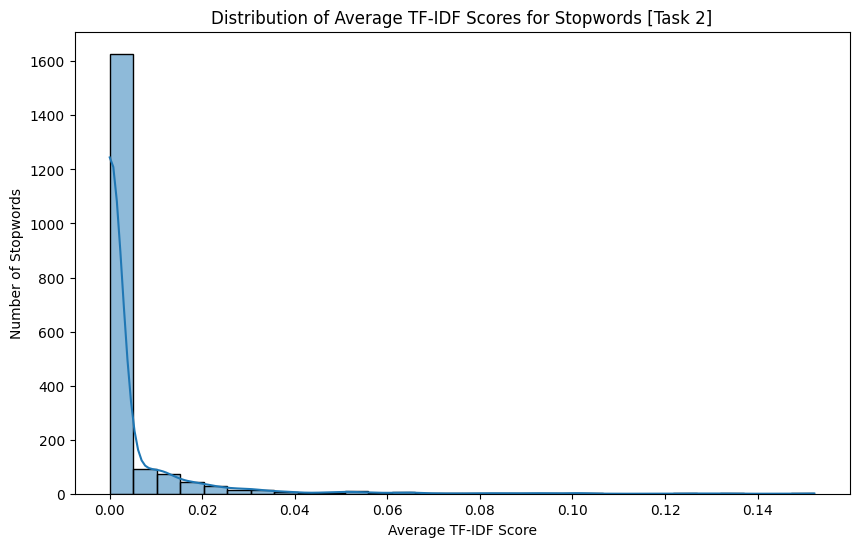

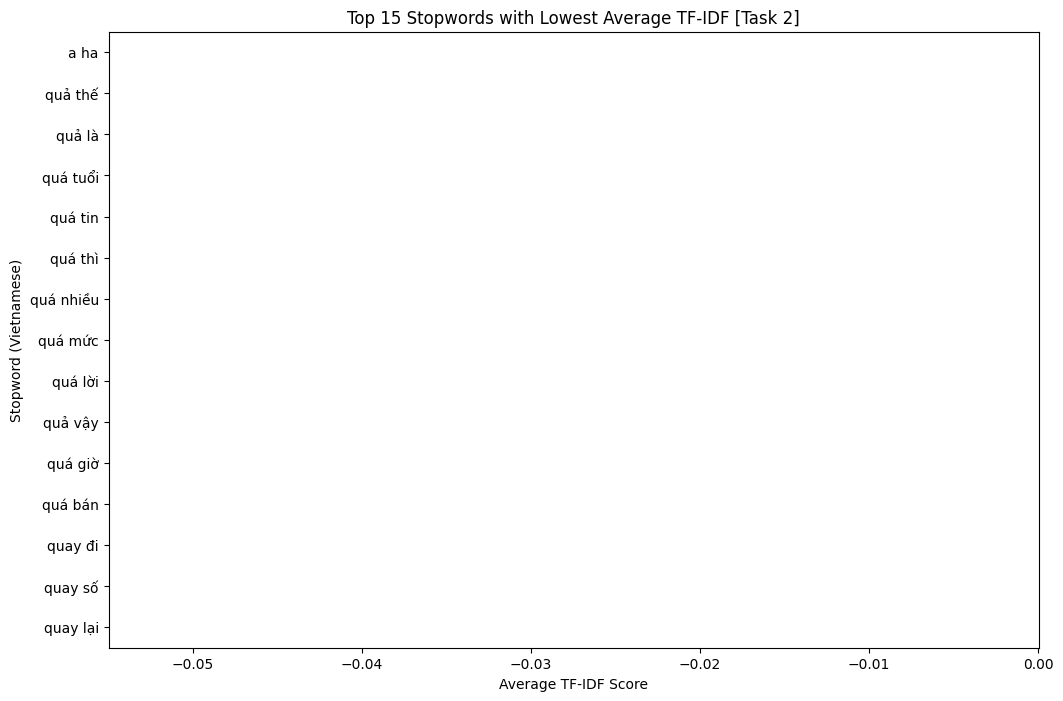

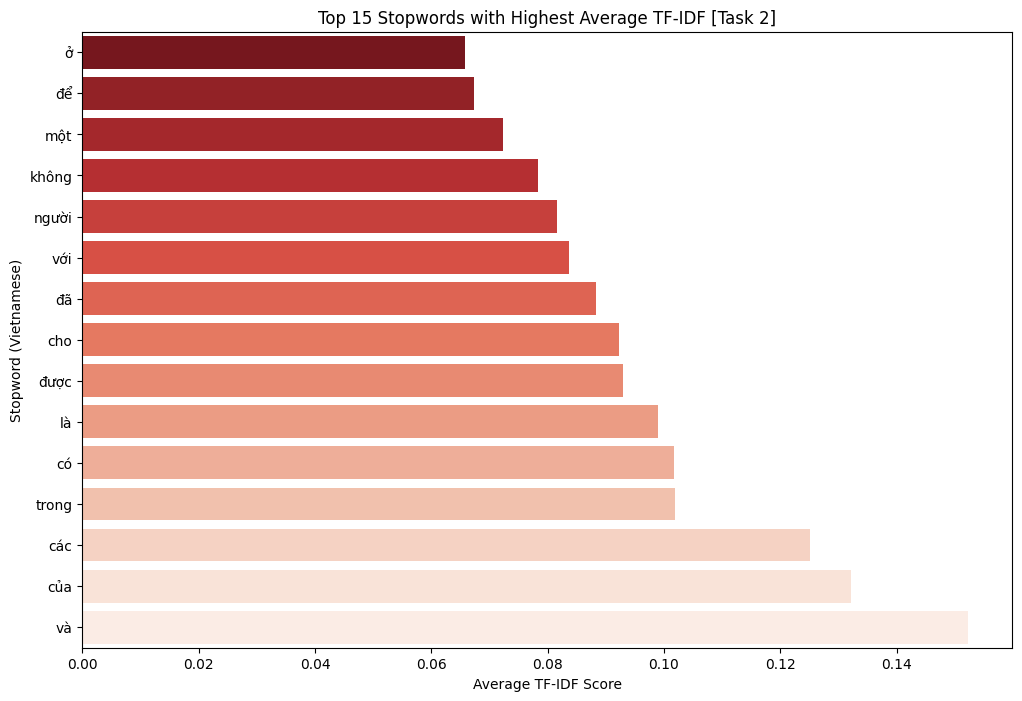

In [25]:
plt.figure(figsize=(10, 6)) 
sns.histplot(tfidf_stats_df['Average TF-IDF'], bins=30, kde=True)
plt.title('Distribution of Average TF-IDF Scores for Stopwords [Task 2]')
plt.xlabel('Average TF-IDF Score')
plt.ylabel('Number of Stopwords')

plt.savefig('plot/task2_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(x='Average TF-IDF', y='Stopword', data=lowest_15_df, palette='Blues_r')
plt.title('Top 15 Stopwords with Lowest Average TF-IDF [Task 2]') 
plt.xlabel('Average TF-IDF Score')
plt.ylabel('Stopword (Vietnamese)')
min_non_zero = tfidf_stats_df[tfidf_stats_df['Average TF-IDF'] > 0]['Average TF-IDF'].min()
if not pd.isna(min_non_zero) and lowest_15_df['Average TF-IDF'].max() < min_non_zero * 10:
     plt.xlim(right=min_non_zero * 10) 

plt.savefig('plot/task2_bottom15.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(x='Average TF-IDF', y='Stopword', data=highest_15_df, palette='Reds_r')
plt.title('Top 15 Stopwords with Highest Average TF-IDF [Task 2]')
plt.xlabel('Average TF-IDF Score')
plt.ylabel('Stopword (Vietnamese)')

plt.savefig('plot/task2_top15.png', dpi=300, bbox_inches='tight')
plt.show()

### **Findings:**

1.  **Majority behave as Expected:** A substantial portion of the stopwords (1244 out of 1942, approx. 64%) showed near-zero average TF-IDF scores (< 1e-5). This indicates that about two-thirds of the standard stopwords behave as expected in this news corpus – they appear widely or infrequently enough not to strongly differentiate between news topics.
   
2.  **Least Average TF-IDF** Words in this category are among those with effectively zero average TF-IDF. They are mostly words with very specific meaning and rarely show up (`aha` - Ahah, `quả thế` - actually,..). They offer some signal for distinguishing between the news categories in this dataset.
   
3.  **Highest Average TF-IDF** Common, high-frequency stop words dominate the list of highest average TF-IDF scores, including `và` (and), `của` (of), `các` (the), `có` (have), `là` (is/to be), and `không` (not), with scores up to ~0.14. While these values are low in the TF-IDF scale, they are high relative to the expected ideal score of zero for stopwords. Which supports make sense since their use are very general for all categories


**Conclusion:** 

These results show that **real-world language** use show **some matching (64%)** with the theoretical assumption that stopwords always contain zero informational value. While most stopwords can be safely removed, certain high-frequency grammatical markers still exhibit small but non-negligible category-specific bias.

However, a subset of frequent stop words that retains minor discriminative signal might still be needed for real-word retrieval.

# Question 3: Identify Top 100 TF-IDF Stopwords & Compare

In [26]:

def get_stopword_candidates_step3(tfidf_stats_df: pd.DataFrame, 
                                  stopword_all_category_scores: dict, 
                                  top_n: int = 100) -> list[tuple[str, float, int]]:
    """
    Identifies stopword candidates based on TF-IDF statistics.
    """
    print(f"Generating stopword candidates for Step 3 (top {top_n})...")

    data = []
    for index, row in tfidf_stats_df.iterrows():
        word = row['Stopword']
        
        if word in stopword_all_category_scores and stopword_all_category_scores[word]:
             avg_score = np.mean(stopword_all_category_scores[word])
             ncategories = sum(1 for score in stopword_all_category_scores[word] if score > 1e-9)
        else:
             avg_score = 0.0
             ncategories = 0 

        data.append((word, avg_score, ncategories))

    # Sort: 1. By ncategories (descending), 2. By avg_score (ascending)
    data.sort(key=lambda e: (-e[2], e[1]))

    print("Stopword candidates generated and sorted.")
    return data[:top_n]



if 'tfidf_stats_df' in locals() and 'stopword_tfidf_scores' in locals():
    
    stopword_candidates = get_stopword_candidates_step3(
        tfidf_stats_df, 
        stopword_tfidf_scores,
        top_n=100
    )

    # Get the top 10 candidates
    top_10_candidates = stopword_candidates[:10]

    # Extract just the words into a list
    words_to_translate = [word for word, _, _ in top_10_candidates]

    try:
        translated_words = translate_words(words_to_translate)
    except Exception as e:
        print(f"Error during translation: {e}. Defaulting to 'Error'.")
        translated_words = ["Error"] * 10 # Create a list of "Error" placeholders


    for i, (word, avg_score, ncategories) in enumerate(top_10_candidates):
        translation = translated_words[i] # Get the translation from our list
        
        print(f"{i+1:>2}. Word (VI): {word:<12} | Word (EN): {translation:<15} | Avg TF-IDF: {avg_score:.4f} | Categories: {ncategories}")


else:
    print("Error: 'tfidf_stats_df' or 'stopword_tfidf_scores' not found.")
    print("Please ensure the new Task 2 cell was executed successfully.")

Generating stopword candidates for Step 3 (top 100)...
Stopword candidates generated and sorted.
 1. Word (VI): bấy lâu nay  | Word (EN): for so long     | Avg TF-IDF: 0.0001 | Categories: 8
 2. Word (VI): nào là       | Word (EN): Which is        | Avg TF-IDF: 0.0001 | Categories: 8
 3. Word (VI): phần nhiều   | Word (EN): much            | Avg TF-IDF: 0.0002 | Categories: 8
 4. Word (VI): qua ngày     | Word (EN): day by day      | Avg TF-IDF: 0.0002 | Categories: 8
 5. Word (VI): trước sau    | Word (EN): before and after | Avg TF-IDF: 0.0002 | Categories: 8
 6. Word (VI): vâng         | Word (EN): Yes             | Avg TF-IDF: 0.0002 | Categories: 8
 7. Word (VI): đáng lẽ      | Word (EN): should          | Avg TF-IDF: 0.0002 | Categories: 8
 8. Word (VI): biết đâu     | Word (EN): who knows       | Avg TF-IDF: 0.0003 | Categories: 8
 9. Word (VI): tức thì      | Word (EN): instant         | Avg TF-IDF: 0.0003 | Categories: 8
10. Word (VI): lớn nhỏ      | Word (EN): big and small  

In [27]:

if ('tfidf_stats_df' not in locals() or 
    'stopword_tfidf_scores' not in locals() or 
    'categories' not in locals() or
    'vietnamese_stopwords_set' not in locals()):
    
    print("Error: Required variables from Task 2 are not found.")
    print("Please ensure the new Task 2 cell was executed successfully.")

else:
    # thresholds to test
    thresholds = [0.001, 0.005, 0.01, 0.02]
    overlap_results = []
    
    analysis_df = tfidf_stats_df.copy()
    num_categories = len(categories)

    for t in thresholds:
        print(f"\nProcessing threshold = {t}...")

        analysis_df['Low_Score_Count'] = analysis_df['Stopword'].apply(
            lambda w: sum([s < t for s in stopword_tfidf_scores[w]])
        )
        analysis_df['Low_Score_Ratio'] = analysis_df['Low_Score_Count'] / num_categories

        analysis_df_sorted = analysis_df.sort_values(
            ['Low_Score_Ratio', 'Average TF-IDF'],
            ascending=[False, True]
        )

        top_100_set = set(analysis_df_sorted.head(100)['Stopword'])
        common = top_100_set.intersection(vietnamese_stopwords_set)
        overlap_percentage = (len(common) / 100) * 100 

        print(f"Top 100 stopwords identified for threshold {t}.")
        print(f"Overlap with default list: {len(common)} words ({overlap_percentage:.2f}%)")

        overlap_results.append({
            'Threshold': t,
            'Top 100 Size': len(top_100_set),
            'Common Words': len(common),
            'Overlap %': overlap_percentage
        })



Processing threshold = 0.001...
Top 100 stopwords identified for threshold 0.001.
Overlap with default list: 100 words (100.00%)

Processing threshold = 0.005...
Top 100 stopwords identified for threshold 0.005.
Overlap with default list: 100 words (100.00%)

Processing threshold = 0.01...
Top 100 stopwords identified for threshold 0.01.
Overlap with default list: 100 words (100.00%)

Processing threshold = 0.02...
Top 100 stopwords identified for threshold 0.02.
Overlap with default list: 100 words (100.00%)


### Findings


1. **Top 100 stopwords** were identified for each threshold.
   
2. For **all thresholds**, the **overlap with the default Vietnamese stopword list was 100%**, meaning every stopword identified by TF-IDF also exists in the standard list.
   
#### Interpretation

- These words have **low discriminative power** for distinguishing documents in different categories, which is exactly what we expect from stopwords.
  
- The thresholds used (0.001 → 0.02) did not change the results, suggesting that these words are **extremely consistent in frequency** and TF-IDF magnitude across the corpus.
  
- The TF-IDF-based selection method **confirms the validity of the default stopword list** for Vietnamese in information retrieval tasks.

#### Conclusion

This analysis support the theory that using **TF-IDF to identify stopwords** is effective and aligns with linguistic intuition. Words that appear across many documents with high frequency naturally receive low TF-IDF scores, making them ideal candidates for exclusion in retrieval or text processing tasks. 


# Question 4: Identify stopwords (>= 50% category)

In [37]:
TASK4_ZERO_TFIDF_PKL = os.path.join(PKL_FOLDER, 'task4.pkl')

if os.path.exists(TASK4_ZERO_TFIDF_PKL):
    print(f"Loading cached Task 4 results from {TASK4_ZERO_TFIDF_PKL}...")
    with open(TASK4_ZERO_TFIDF_PKL, 'rb') as f:
        cached_data = pickle.load(f)
        zero_tfidf_stopwords_list = cached_data['zero_tfidf_list']
        stopword_zero_counts = cached_data['zero_counts']
    print(f"Task 4 results loaded. Total stopwords meeting criteria: {len(zero_tfidf_stopwords_list)}")

else:
    print(f"Cache not found for Task 4. Running analysis...")


    categories = vn_df['label'].unique()
    num_categories = len(categories)

    # Threshold: >= 50% of categories
    threshold_categories = np.ceil(num_categories / 2.0)


    stopword_is_zero_scores = {word: [] for word in vietnamese_stopwords_set}

    # calculate TF-IDF per category
    for category in tqdm(categories, desc="Processing Categories for Task 4"):
        category_texts = vn_df[vn_df['label'] == category]['content'].tolist()
        tfidf_vectorizer = TfidfVectorizer(tokenizer=vn_tokenizer, stop_words=None)

        try:
            tfidf_matrix = tfidf_vectorizer.fit_transform(category_texts)
            feature_names = tfidf_vectorizer.get_feature_names_out()
            vocab_index = {word: idx for idx, word in enumerate(feature_names)}

            for stopword in vietnamese_stopwords_set:
                if stopword in vocab_index:
                    avg_score = tfidf_matrix[:, vocab_index[stopword]].mean()
                    is_zero = avg_score < 1e-6  
                    stopword_is_zero_scores[stopword].append(is_zero)
                else:
                    stopword_is_zero_scores[stopword].append(True)  # not in vocab => zero

        except ValueError as e:
            print(f"Skipping category {category} due to error: {e}")
            for stopword in vietnamese_stopwords_set:
                stopword_is_zero_scores[stopword].append(True)

    # Identify stopwords meeting zero-score threshold
    zero_tfidf_stopwords_list = []
    stopword_zero_counts = {}  
    
    for stopword, zero_flags in stopword_is_zero_scores.items():
        zero_count = sum(zero_flags)
        stopword_zero_counts[stopword] = zero_count
        if zero_count >= threshold_categories:
            zero_tfidf_stopwords_list.append(stopword)

    # Save results dictionary
    results_to_save = {
        'zero_tfidf_list': zero_tfidf_stopwords_list,
        'zero_counts': stopword_zero_counts
    }
    with open(TASK4_ZERO_TFIDF_PKL, 'wb') as f:
        pickle.dump(results_to_save, f)
    print(f"Task 4 results saved. Total stopwords meeting criteria: {len(zero_tfidf_stopwords_list)}")



Loading cached Task 4 results from pkl_folder\task4.pkl...
Task 4 results loaded. Total stopwords meeting criteria: 1365


In [38]:
# Compare with default Vietnamese stopword list
zero_tfidf_stopwords_set = set(zero_tfidf_stopwords_list)
common_stopwords_task4 = zero_tfidf_stopwords_set.intersection(vietnamese_stopwords_set)

print(f"\nStopwords with TF-IDF Zero in >= {threshold_categories:.0f} categories")
print(f"Original Vietnamese stopword list size: {len(vietnamese_stopwords_set)}")
print(f"Zero TF-IDF stopwords: {len(zero_tfidf_stopwords_set)}")
print(f"Overlap with default list: ({len(common_stopwords_task4)/len(vietnamese_stopwords_set)*100:.2f}%)")




Stopwords with TF-IDF Zero in >= 4 categories
Original Vietnamese stopword list size: 1942
Zero TF-IDF stopwords: 1365
Overlap with default list: (70.29%)


In [40]:

top_10_zero_tfidf = sorted(zero_tfidf_stopwords_list, key=lambda w: -stopword_zero_counts[w])[:10]

if top_10_zero_tfidf and translator:
    print("\nTop 10 zero-TFIDF stopwords with translation:")
    translations_task4 = translate_words(top_10_zero_tfidf)
    translation_df_task4 = pd.DataFrame({
        'Stopword (VI)': top_10_zero_tfidf,
        'Translation (EN)': translations_task4,
    })
    print(translation_df_task4.to_markdown(index=False))
elif top_10_zero_tfidf:
    print("\nTop 10 zero-TFIDF stopwords (translator unavailable):")
    for w in top_10_zero_tfidf:
        print(f"{w} - Zero in {stopword_zero_counts[w]} categories")
else:
    print("\nNo stopwords met the zero TF-IDF criteria.")


Top 10 zero-TFIDF stopwords with translation:
| Stopword (VI)   | Translation (EN)   |
|:----------------|:-------------------|
| chịu chưa       | Can you wait?      |
| sự thế          | situation          |
| dùng làm        | used to make       |
| là vì           | is because         |
| ăn làm          | eat and work       |
| đưa tay         | give your hand     |
| khó mở          | difficult to open  |
| chưa kể         | not to mention     |
| mỗi lần         | every time         |
| nói với         | tell               |


## Findings
1. Original NLTK List Size: 1942 words

2. Words Passing the Test: 1365 words

3. Overlap Percentage: 70.29%

## Interpretation
**Strong Correlation:** The 70.29% overlap is a very strong result. It demonstrates that over two-thirds of the words in the NLTK list are, in fact, non-informative across at least half of the topics in this specific corpus. This validates the general quality of the NLTK list and supports the idea that many stopwords are "stopwords" precisely because they have no discriminant value.

**The "Informative" Stopwords (The Missing 30%):** The more interesting finding is that 577 words (1942 - 1365) from the NLTK list failed the test. This means nearly 30% of NLTK's "stopwords" do carry a meaningful TF-IDF score in more than half of the categories.

## Conclusion
This suggests that TF-IDF method can work to find stopwords for this corpus. While these 577 words are "stopwords" in a general linguistic sense, they appear to hold some topic-specific, discriminant power within this particular dataset. Removing them blindly could potentially reduce the accuracy of a classification model.